In [3]:
from bhpwave.trajectory.inspiral import IntegrateInspiralGeneratorBase
from bhpwave.trajectory.inspiral import TrajectoryData, InspiralGenerator
from bhpwave.waveform import KerrWaveform
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from bhpwave.trajectory.inspiral import spin_of_chi, omega_of_a_alpha, pn_flux_noprefactor
from bhpwave.trajectory.geodesic import kerr_circ_geo_radius, kerr_isco_frequency, kerr_circ_geo_orbital_frequency

In [5]:
traj = TrajectoryData()

In [6]:
def Edot_test(chi, alpha, R):
    a = spin_of_chi(chi)
    omega = omega_of_a_alpha(a, alpha)
    r0 = kerr_circ_geo_radius(a, omega)
    if traj.range_check(a, omega):
        return traj.scaled_energy_flux(a, r0)/pn_flux_noprefactor(omega)*(1 - 0.5*R**2)
    else:
        return 0.

In [7]:
test_gen = IntegrateInspiralGeneratorBase(Edot_test)

In [8]:
kerr_gen_mod = KerrWaveform(trajectory_data=test_gen)

In [9]:
kerr_gen_GR = KerrWaveform()

In [10]:
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses
a = 0.9 # dimensionless spin of the primary
p0 = 6.55 # initial semi-latus rectum
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc
Phi_phi0 = 0.2 # initial azimuthal position of the secondary
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 5.0  # time steps in seconds
T = 1.0  # waveform duration in years

injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

In [25]:
R = 5e-5
h = kerr_gen_mod(*injection_paramters, R)
h_GR = kerr_gen_GR(*injection_paramters)

In [40]:
from lisatools.diagnostic import inner_product

def mismatch_func(h, hGR, dt, freq = None):
    h = h[:hGR.shape[0]]
    hGR = hGR[:h.shape[0]]
    h1 = [h.real, h.imag]
    h2 = [hGR.real, hGR.imag]
    if freq is None:
        freq = np.fft.rfftfreq(h1[0].shape[0], d=dt)[1:]
        h1f = np.fft.rfft(h1)[:,1:]*dt
        h2f = np.fft.rfft(h2)[:,1:]*dt
    else:
        h1f = h1
        h2f = h2
    num = inner_product(h1f, h2f, f_arr=freq, PSD="cornish_lisa_psd")
    snr1 = inner_product(h1f, h1f, f_arr=freq, PSD="cornish_lisa_psd")
    snr0 = inner_product(h2f, h2f, f_arr=freq, PSD="cornish_lisa_psd")
    return 1-num/np.sqrt(snr1*snr0)

In [29]:
edotH = np.load("data/bhpwave_edot_H.npy")
edotI = np.load("data/bhpwave_edot_Infty.npy")

In [34]:
from bhpwave.spline import BicubicSpline

In [35]:
def flux_to_norm_spline(Efluxraw):
    #reconstruct mesh (from how data was stored)
    #remark chi and alpha are functions of a and r
    chi_flux_array = np.linspace(0, 1, Efluxraw.shape[0])
    alpha_flux_array = np.linspace(0, 1, Efluxraw.shape[1])
    ALPHA_FLUX, CHI_FLUX = np.meshgrid(alpha_flux_array, chi_flux_array)
    SPIN_FLUX = spin_of_chi(CHI_FLUX)
    OMEGA_FLUX = omega_of_a_alpha(SPIN_FLUX, ALPHA_FLUX)

    #will want to normalize to PN flux
    Efluxraw_norm=Efluxraw/pn_flux_noprefactor(OMEGA_FLUX)
    flux_spline = BicubicSpline(chi_flux_array, alpha_flux_array, Efluxraw_norm, bc = 'E(3)')
    return flux_spline

In [36]:
EdotH = flux_to_norm_spline(edotH)
EdotI = flux_to_norm_spline(edotI)

In [37]:
def Edot_test(chi, alpha, C):
    a = spin_of_chi(chi)
    omega = omega_of_a_alpha(a, alpha)
    if traj.range_check(a, omega):
        return (EdotH(chi, alpha)*(1 - C) + EdotI(chi, alpha))
    else:
        return 0.

In [38]:
test_gen = IntegrateInspiralGeneratorBase(Edot_test)
kerr_gen_mod = KerrWaveform(trajectory_data=test_gen)
kerr_gen_GR = KerrWaveform()

In [124]:
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses
a = 0.8 # dimensionless spin of the primary
p0 = 10 # initial semi-latus rectum
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits
qK = 1.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 3.3  # polar sky angle
phiS = -0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc
Phi_phi0 = 0.2 # initial azimuthal position of the secondary
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 10.0  # time steps in seconds
T = 1./12  # waveform duration in years

injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

injection_paramters_2 = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0 + 0.1*np.pi, Phi_theta0, Phi_r0, 
                       dt, T]

In [139]:
C = 1e-4
h_GR = kerr_gen_mod(*injection_paramters, 0.)

In [140]:
def marginalize_mismatch(dphi, T):
    injection_paramters_2 = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0 + dphi, Phi_theta0, Phi_r0, 
                       dt, T]
    
    h = kerr_gen_mod(*injection_paramters_2, C)
    return mismatch_func(h, h_GR, dt=dt)

In [141]:
# mismatch_list = []
# for T in [1./12., 2./12., 3./12., 4./12., 5./12., 6./12., 7./12., 8./12., 9./12., 10./12., 11./12., 12/12.]:
#     print(T)
#     injection_paramters = [M, mu, a, p0, e0, x0, 
#                        dist, qS, phiS, qK, phiK, 
#                        Phi_phi0, Phi_theta0, Phi_r0, 
#                        dt, T]
#     h_GR = kerr_gen_mod(*injection_paramters, 0.)
#     test=[marginalize_mismatch(phi, T) for phi in np.linspace(0, 2.*np.pi, 10)]
#     mismatch_list.append(np.min(test))

mismatch_list = []
for T in [1./12., 3./12., 5./12., 7./12., 9./12., 11./12., 13/12.]:
    print(T)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]
    h_GR = kerr_gen_mod(*injection_paramters, 0.)
    test=[marginalize_mismatch(phi, T) for phi in np.linspace(0, 2.*np.pi, 10)]
    mismatch_list.append(np.min(test))

0.08333333333333333
0.25
0.4166666666666667
0.5833333333333334
0.75
0.9166666666666666
1.0833333333333333


In [142]:
# Cvals = {}
Cvals[C] = mismatch_list

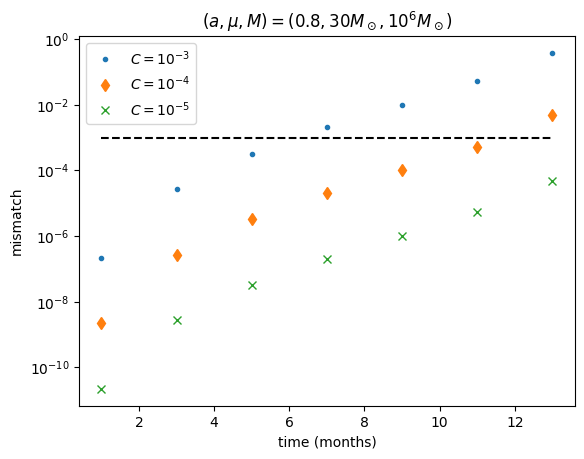

In [144]:
plt.plot(np.arange(1, 14, 2), (Cvals[1e-3]), '.', label = "$C = 10^{-3}$")
plt.plot(np.arange(1, 14, 2), (Cvals[1e-4]), 'd', label = "$C = 10^{-4}$")
plt.plot(np.arange(1, 14, 2), (Cvals[1e-5]), 'x', label = "$C = 10^{-5}$")
plt.plot(np.arange(1, 14, 2), np.arange(1, 14, 2)*0 + 1e-3, 'k--')
plt.yscale('log')
plt.ylabel('mismatch')
plt.xlabel('time (months)')
plt.legend()
plt.title("$(a, \mu, M) = (0.8, 30 M_\odot, 10^6 M_\odot)$")
plt.show()

In [ ]:
# mismatch_list = []
# for T in [1./12., 2./12., 3./12., 4./12., 5./12., 6./12., 7./12., 8./12.]:
#     print(T)
#     injection_paramters = [M, mu, a, p0, e0, x0, 
#                        dist, qS, phiS, qK, phiK, 
#                        Phi_phi0, Phi_theta0, Phi_r0, 
#                        dt, T]
#     h_GR = kerr_gen_mod(*injection_paramters, 0.)
#     test=[marginalize_mismatch(phi, T) for phi in np.linspace(0, 2.*np.pi, 25)]
#     mismatch_list.append(np.min(test))

In [121]:
# avals = {}
avals[a] = mismatch_list

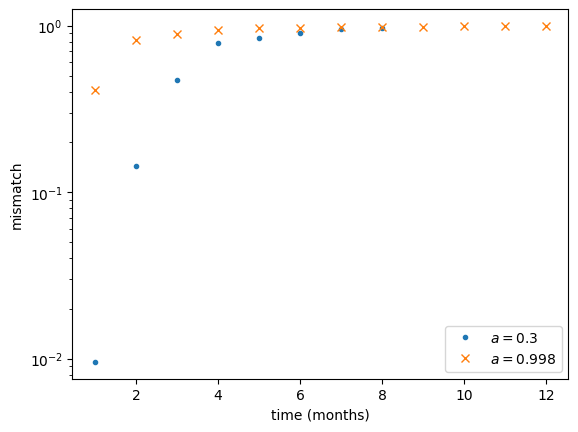

In [123]:
plt.plot(np.arange(1, 9), (avals[0.3]), '.', label = "$a = 0.3$")
plt.plot(np.arange(1, 13), (avals[0.998]), 'x', label = "$a = 0.998$")
plt.yscale('log')
plt.ylabel('mismatch')
plt.xlabel('time (months)')
plt.legend()
plt.show()